In [3]:
# importando as bibliotecas 
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
import requests as rq
import zipfile as zp
import io
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap 
import pandas as pd
import numpy as np


# URL do arquivo ZIP para mapa coroplético de municipios
link = "http://www.usp.br/nereus/wp-content/uploads/BR_Municipios_2021.zip"

# Fazer o download do arquivo ZIP e extrair seu conteúdo
respons = rq.get(link)
zip_fil = zp.ZipFile(io.BytesIO(respons.content))
zip_fil.extractall("/content/brasil_municipios_folder")

# Importar o shapefile
brasil_municipios = gpd.read_file("/content/brasil_municipios_folder/BR_Municipios_2021.shp")

#-----------------------------------------------------------------------------------------------------------
# importando arquivos 
# URL do arquivo ZIP para mapa coroplético
url = "http://www.usp.br/nereus/wp-content/uploads/BR_UF_2021.zip"

# Fazer o download do arquivo ZIP e extrair seu conteúdo
response = rq.get(url)
zip_file = zp.ZipFile(io.BytesIO(response.content))
zip_file.extractall("/content/brasil_estados_folder")

# Importar o shapefile
brasil_estados = gpd.read_file("/content/brasil_estados_folder/BR_UF_2021.shp")

# importando o DataSet anp meses 5 e 6

gas_eta_5=pd.read_csv('https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsan/2023/precos-gasolina-etanol-05.csv' ,sep=';')
gas_eta_6=pd.read_csv('https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsan/2023/precos-gasolina-etanol-06.csv',sep=';')
gas_eta=pd.concat([gas_eta_5,gas_eta_6])

# dias da semana
dia_semana={'2023-05-01': 'Segunda-feira', '2023-05-02': 'Terça-feira', '2023-05-03': 'Quarta-feira', '2023-05-04': 'Quinta-feira', '2023-05-05': 'Sexta-feira', '2023-05-06': 'Sábado', '2023-05-07': 'Domingo', '2023-05-08': 'Segunda-feira', '2023-05-09': 'Terça-feira', '2023-05-10': 'Quarta-feira', '2023-05-11': 'Quinta-feira', '2023-05-12': 'Sexta-feira', '2023-05-13': 'Sábado', '2023-05-14': 'Domingo', '2023-05-15': 'Segunda-feira', '2023-05-16': 'Terça-feira', '2023-05-17': 'Quarta-feira', '2023-05-18': 'Quinta-feira', '2023-05-19': 'Sexta-feira', '2023-05-20': 'Sábado', '2023-05-21': 'Domingo', '2023-05-22': 'Segunda-feira', '2023-05-23': 'Terça-feira', '2023-05-24': 'Quarta-feira', '2023-05-25': 'Quinta-feira', '2023-05-26': 'Sexta-feira', '2023-05-27': 'Sábado', '2023-05-28': 'Domingo', '2023-05-29': 'Segunda-feira', '2023-05-30': 'Terça-feira', '2023-05-31': 'Quarta-feira', '2023-06-01': 'Quinta-feira', '2023-06-02': 'Sexta-feira', '2023-06-03': 'Sábado', '2023-06-04': 'Domingo', '2023-06-05': 'Segunda-feira', '2023-06-06': 'Terça-feira', '2023-06-07': 'Quarta-feira', '2023-06-08': 'Quinta-feira', '2023-06-09': 'Sexta-feira', '2023-06-10': 'Sábado', '2023-06-11': 'Domingo', '2023-06-12': 'Segunda-feira', '2023-06-13': 'Terça-feira', '2023-06-14': 'Quarta-feira', '2023-06-15': 'Quinta-feira', '2023-06-16': 'Sexta-feira', '2023-06-17': 'Sábado', '2023-06-18': 'Domingo', '2023-06-19': 'Segunda-feira', '2023-06-20': 'Terça-feira', '2023-06-21': 'Quarta-feira', '2023-06-22': 'Quinta-feira', '2023-06-23': 'Sexta-feira', '2023-06-24': 'Sábado', '2023-06-25': 'Domingo', '2023-06-26': 'Segunda-feira', '2023-06-27': 'Terça-feira', '2023-06-28': 'Quarta-feira', '2023-06-29': 'Quinta-feira', '2023-06-30': 'Sexta-feira'}


# estados da união 
estados = {"AC": "Acre","AL": "Alagoas","AP": "Amapá","AM": "Amazonas","BA": "Bahia","CE": "Ceará","DF": "Distrito Federal","ES": "Espírito Santo","GO": "Goiás","MA": "Maranhão","MT": "Mato Grosso","MS": "Mato Grosso do Sul","MG": "Minas Gerais","PA": "Pará","PB": "Paraíba","PR": "Paraná","PE": "Pernambuco","PI": "Piauí","RJ": "Rio de Janeiro","RN": "Rio Grande do Norte","RS": "Rio Grande do Sul","RO": "Rondônia","RR": "Roraima","SC": "Santa Catarina","SP": "São Paulo","SE": "Sergipe","TO": "Tocantins"}

# regiões
siglas_para_regioes = {
    'SE':'Sudeste',
    'S' :'Sul',
    'N' : 'Norte',
    'NE': 'Nordeste',
    'CO': 'Centro\noeste'
}

# retirando colunas que não serão utilizadas do DataSet

gas_eta=pd.DataFrame(gas_eta,columns=['Regiao - Sigla','Estado - Sigla','Municipio','Produto','Data da Coleta','Valor de Venda','Bandeira'])

# criando a coluna com os dias da semana

gas_eta['Dia da Semana']=gas_eta['Data da Coleta']
gas_eta['Dia da Semana']=gas_eta['Dia da Semana'].apply(lambda x: dia_semana['-'.join(x.split('/')[::-1])])

# transformando os dados da coluna valor da venda para float
gas_eta['Valor de Venda']=gas_eta['Valor de Venda'].apply(lambda x: float(x.replace(',','.')))

# transformando os dados de data para datetime
gas_eta['Data da Coleta']=pd.to_datetime(gas_eta['Data da Coleta'],dayfirst=True)

# trocando o nome de siglas para o nome dos estados 
gas_eta['Estado - Sigla']=gas_eta['Estado - Sigla'].apply(lambda x:estados[x])

# trocando o nome das siglas das regiões para o nome das regiões
gas_eta['Regiao - Sigla']=gas_eta['Regiao - Sigla'].apply(lambda x:siglas_para_regioes[x])

# manipulando o nome dos municipios
gas_eta['Municipio']=gas_eta['Municipio'].apply(lambda x:x.replace(' ','\n'))

# trocando o nome das colunas em quê o valor foi alterado
gas_eta.rename(columns={'Estado - Sigla':'Estado','Regiao - Sigla':'Regiao'},inplace=True)


In [38]:
def lancamento_dados():
    percentual_semana=gas_eta['Dia da Semana'].value_counts()/gas_eta['Dia da Semana'].value_counts().sum()*100
    fig=plt.figure(figsize=(10,7))
    rotulacao(plt,plt.bar(percentual_semana.index,percentual_semana.values),altura=1.5,s1='',s2='%',font=10)
    quadro(['bottom'])
    plt.xticks(percentual_semana.index,color='black',fontweight= 'bold',fontsize=10, fontstyle= 'italic')
    plt.tick_params(axis='both',color='grey')
    plt.yticks([])
    plt.title('lançamento diario dos dados\n\n\n',color='royalblue',fontweight= 'bold',fontsize=15, fontstyle= 'italic',loc='left')
    plt.show()

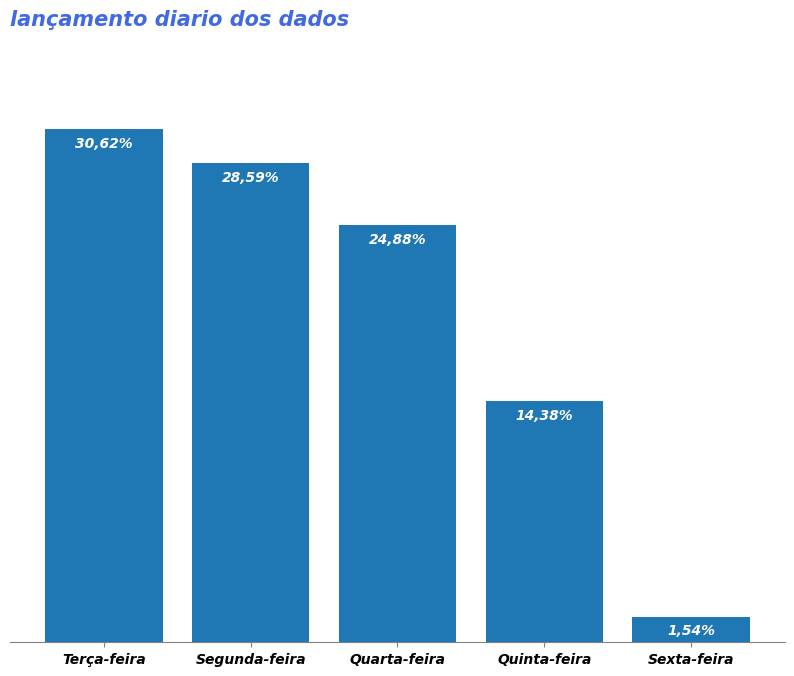

In [40]:
lancamento_dados()